# **Modelamiento**

## Librerías

In [ ]:
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
#Generales
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Proceso de Modelación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,median_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, ShuffleSplit

from sklearn.feature_extraction.text import CountVectorizer

## Lectura Información

In [ ]:
#Descargar datasets desde github
!git clone https://github.com/andres-soto-h/monografia-udea-eacd.git

Cloning into 'monografia-udea-eacd'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [ ]:
#Lectura del dataset transformado
df_propiedades=pd.read_csv('/content/monografia-udea-eacd/df_prop_clean_12082021.csv', delimiter=';', encoding='latin1')

In [ ]:
df_propiedades.rename(columns={"municipio":"ubicacion"}, inplace=True)

**NOTA:** se decide eliminar la información del municipio de **La Unión**.

In [ ]:
mask_union = df_propiedades['ubicacion']!='la uniÃ³n'
df_propiedades = df_propiedades[mask_union]

In [ ]:
df_propiedades.reset_index(inplace=True)
df_propiedades.drop(columns=['index'], inplace=True)

In [ ]:
df_propiedades['ubicacion'].value_counts()

rionegro                  1241
el retiro                  439
la ceja                    342
guarne                     196
marinilla                  117
el carmen de viboral        62
san antonio de pereira      38
llanogrande                 31
santuario                   15
Name: ubicacion, dtype: int64

**Nota2:** Se convierte la variable Estrato en ordinal

In [ ]:
df_propiedades['estrato'] = df_propiedades['estrato'].replace('Campestre', '0')
df_propiedades['estrato'] = df_propiedades['estrato'].astype(int)
df_propiedades['estrato'].value_counts()

4    947
5    636
3    584
0    162
6     89
2     58
1      5
Name: estrato, dtype: int64

## **Ajuste del Modelo**

### Funciones

In [ ]:
#Métricas datos transformados
def median_absolute_error2(y_true, y_pred):
  return median_absolute_error(np.expm1(y_true), np.expm1(y_pred))

def mean_squared_error2(y_true, y_pred):
  return mean_squared_error(np.expm1(y_true), np.expm1(y_pred), squared=False)


def mean_absolute_percentage_error2(y_true, y_pred):
  return mean_absolute_percentage_error(np.expm1(y_true), np.expm1(y_pred))
  
def r2_score2(y_true, y_pred):
  return r2_score(np.expm1(y_true), np.expm1(y_pred))

In [ ]:
def div_train_test(X, y, var_stratify = ''):
  
  if var_stratify != '': 
    x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.9, stratify = X[var_stratify],  random_state = 42)

    var_stratify_train = x_train[var_stratify]
    #ubicacion_test = X_test['ubicacion']

    x_train.drop(var_stratify,axis=1, inplace=True)
    x_test.drop(var_stratify,axis=1, inplace=True)

    #Variable Objetivo Transformada
    y_train_t = np.log1p(y_train)
    y_test_t = np.log1p(y_test)

    return x_train, x_test, y_train, y_test, y_train_t, y_test_t, var_stratify_train

  else:
    x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.9,  random_state = 42)

    #Variable Objetivo Transformada
    y_train_t = np.log1p(y_train)
    y_test_t = np.log1p(y_test)
  
  return x_train, x_test, y_train, y_test, y_train_t, y_test_t

def busqueda_hiperparametros(x_train, y_train, var_stratify_train, estimator,param_grid = [] , scoring_med = 'neg_median_absolute_error', transf=False):

  if len(var_stratify_train) != 0:
    
    print('Seccion Stratify')
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
    stratified = sss.split(x_train, var_stratify_train)
    
    if transf: 
      print('**para datos transformados**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error2), 'r2':make_scorer(r2_score2) , 'rmse':make_scorer(mean_squared_error2), 'mape':make_scorer(mean_absolute_percentage_error2)}
    else:
      print('**para datos sin transformar**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error), 'r2':make_scorer(r2_score) , 'rmse':make_scorer(mean_squared_error), 'mape':make_scorer(mean_absolute_percentage_error)}
    
    grid = GridSearchCV(estimator, param_grid=param_grid, cv = stratified, scoring = scoring_grid , refit = 'metrica',  return_train_score=True, n_jobs=-1, verbose=8)
    return grid.fit(x_train, y_train)
  
  else:
    print('OutStratify')
    
    if transf: 
      print('**para datos transformados**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error2), 'r2':make_scorer(r2_score2) , 'rmse':make_scorer(mean_squared_error2), 'mape':make_scorer(mean_absolute_percentage_error2)}
    else:
      print('**para datos sin transformar**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error), 'r2':make_scorer(r2_score) , 'rmse':make_scorer(mean_squared_error), 'mape':make_scorer(mean_absolute_percentage_error)}
    
    grid = GridSearchCV(estimator, param_grid=param_grid, scoring = scoring_grid, refit = 'metrica', return_train_score=True, n_jobs=-1, verbose=8 )
    return grid.fit(X_train, y_train)

def metricas(model,y_train, p_train, y_test, p_test): 

  resultados = {
      'parametros' : [model.get_params()['steps'][1][1]],
      'MeAE_train' : [median_absolute_error(y_train,p_train)],
      'MeAE_test'  : [median_absolute_error(y_test, p_test)],
      'MAPE_train' : [mean_absolute_percentage_error(y_train,p_train)],
      'MAPE_test'  : [mean_absolute_percentage_error(y_test, p_test)],
      'r2_train'   : [r2_score(y_train,p_train)],
      'r2_test'    : [r2_score(y_test, p_test)],
      'rmse_train' : [mean_squared_error(y_train,p_train,squared = False)],
      'rmse_test'  : [mean_squared_error(y_test,p_test,squared = False)]
  }
  return pd.DataFrame(resultados)

**División Covariables  y Variable Objetivo**

In [ ]:
data_model=df_propiedades.copy()
data_text=pd.DataFrame(df_propiedades["descripcion"])
columnas_quitar=['url','titulo','descripcion','caractint','caractext','caractsec','otros_datos']
data_model.drop(columnas_quitar, axis=1, inplace=True)
data_model.shape

(2481, 177)

In [ ]:
X = data_model.drop(['precio'], axis=1)
y = data_model['precio']

**OneHotEncoder Variables Categóricas**

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
data_aux = pd.DataFrame(enc.fit_transform(X[['tipo','tipo_propiedad','ubicacion','antiguedad']]).toarray(), columns= enc.get_feature_names(['tipo','tipo_propiedad','ubicacion','antiguedad']))
data_aux['fila'] = range(0, X.shape[0])
data_aux.head()

X.drop(['tipo','tipo_propiedad','antiguedad'],axis=1,inplace=True)
X['fila'] = range(0, X.shape[0])

X = pd.merge(data_aux,X, on = 'fila', how='inner')
X.drop(['fila'], axis=1, inplace=True)
X.shape

(2481, 194)

In [ ]:
X.head(2)

,tipo_Nueva,tipo_Usada,tipo_propiedad_apartaestudio,tipo_propiedad_apartamento,tipo_propiedad_casa,tipo_propiedad_finca,ubicacion_el carmen de viboral,ubicacion_el retiro,ubicacion_guarne,ubicacion_la ceja,ubicacion_llanogrande,ubicacion_marinilla,ubicacion_rionegro,ubicacion_san antonio de pereira,ubicacion_santuario,antiguedad_0,antiguedad_1 a 8 aÃ±os,antiguedad_16 a 30 aÃ±os,antiguedad_9 a 15 aÃ±os,antiguedad_Menos de 1 aÃ±o,antiguedad_MÃ¡s de 30 aÃ±os,area_m2,habitaciones,banos,garajes,balcon,bano_auxiliar,comedor,estudio,servicios_publicos,ventilacion_natural,zona_de_lavanderia,en_conjunto_cerrado,garaje_parqueadero(s),gimnasio,piscina,salon_comunal,vivienda_multifamiliar,zona_infantil,zonas_verdes,...,escalera_de_emergencia,gabinete_de_incendios,ascensor(es)_inteligente(s),industrial,banos_comunales,banos_mixtos,control_de_acceso_digital,servicios_independientes,vivienda_bifamiliar,rociadores_de_agua,finca_ganadera,corrales,cuarto_de_conductores,con_casa_club,finca_agricola,finca_agroganadera,cableado_de_red,puerta_de_seguridad,puerta_electrica,mezzanine,esquinero,acceso_para_camiones,sensor_de_movimiento,auditorio,patio_interno,cuarto_de_servicio.1,cuarto_de_escoltas,panoramica_un_lado,cocineta,finca_avicola,piso_en_alfombra,jaula_de_golf,con_cerca_electrica,oficinas_administrativas,salon_de_videoconferencias,pasaje_comercial,en_club,con_casa_prefabricada,finca_cafetera,ubicacion
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,89.49,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rionegro
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,182.00,4.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,la ceja


### **Gradient Boosting Regression con texto**

#### Análisis de texto - matriz tf

In [ ]:
#Descargar stopwords español
!wget https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt

--2021-09-27 02:52:42--  https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4244 (4.1K) [text/plain]
Saving to: ‘spanish.txt’

spanish.txt         100%[===================>]   4.14K  --.-KB/s    in 0s      

2021-09-27 02:52:42 (49.5 MB/s) - ‘spanish.txt’ saved [4244/4244]



In [ ]:
import re

data_text=pd.DataFrame(df_propiedades["descripcion"])
data_text

#Limpieza básica del texto
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.lower())
data_text['descripcion'] = data_text['descripcion'].apply((lambda x: re.sub(r'[0-9]+','',x)))

In [ ]:
#Corregir error de encoding en textos
def replace_char(text):
  fix_text=text.replace('ã¡','a').replace('ã³','o').replace('ã±','ñ').replace('ã\x81','a').replace('ãº','u').replace('ã©','e').replace('ã\xad','i').replace('ã\x8d','i')
  return fix_text

data_text['descripcion'] = data_text['descripcion'].apply(replace_char)

In [ ]:
data_text['descripcion'][7]

'excelente oportunidad de inversion  casa ubicada en san antonio de pereira,  uno de los mejores sitios para vivir en el oriente ant.  tres pisos  sala-comedor,  cocina integral,  star para sala tv,  tres habitaciones,  tres baños,  balcon,  garaje,  zona de ropas  cerca al parque principal de san antonio de pereira,  supermercados,  iglesia,  farmacia,  transporte,  clinica somer,  comfama parque recreativo.  aeropuerto y tunel de oriente a  minutos. .'

In [ ]:
stopwords = pd.read_csv('spanish.txt', header = None, sep='\n')

In [ ]:
stopwords_list = list(stopwords[0])

In [ ]:
#define vectorizer parameters
count_vectorizer = CountVectorizer(max_features=500, stop_words=stopwords_list)

count_matrix = count_vectorizer.fit_transform(data_text['descripcion']) 

print(count_matrix.shape)

(2481, 500)


In [ ]:
count_matrix.toarray()

array([[0, 0, 0, ..., 0, 3, 1],
       [0, 0, 0, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [ ]:
labels=count_vectorizer.get_feature_names()

df_vectorizer= pd.DataFrame(count_matrix.toarray(), columns=labels)


In [ ]:
df_vectorizer.rename(columns={'ubicacion':'ubicacion_v'}, inplace=True)

In [ ]:
df_vectorizer.shape

(2481, 500)

In [ ]:
df_vectorizer.head(2)

,abad,abierta,abierto,acabados,acceso,acogedora,acueducto,ademas,adicional,administracion,adultos,aeropuerto,agenda,agradable,agua,aguacate,aguas,aire,alcoba,alcobas,alta,alto,altura,ambiente,americana,amigos,amplia,ampliacion,amplias,amplio,amplios,antioqueño,antioquia,antonio,anual,apartaestudio,apartamento,apartamentos,aprox,apto,...,ubicada,ubicado,unidad,unifamiliar,universidad,universidades,urbana,urbanismo,urbanizacion,urbano,urve,util,utiles,valorizacion,vecinos,vehicular,vehiculos,vende,vendo,venta,verde,verdes,vereda,veredal,vestier,via,vias,viboral,vicente,vida,vidrio,vigilancia,visitantes,vista,viva,vivienda,vivir,whatsapp,zona,zonas
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


In [ ]:
X_v = pd.concat([X,df_vectorizer], axis=1)

**División train y Test**

In [ ]:
X_train, X_test, Y_train, Y_test, Y_train_t, Y_test_t, var_stratify_train = div_train_test(X_v, y, var_stratify = 'ubicacion')


#Variable Objetivo Transformada
y_train_t = np.log1p(Y_train)
y_test_t = np.log1p(Y_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


####**Usando Y transformada**

**Búsqueda de hiperparámetros**

In [ ]:
pipe_gbt = Pipeline(steps = [('scaler', StandardScaler()), ('gbt', GradientBoostingRegressor(max_depth=5, min_samples_leaf=5,
                                           min_samples_split=15,
                                           random_state=42))])

In [ ]:
pipe_gbt.fit(X_train, y_train_t)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbt',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=5,
                                           min_samples_split=15,
                                           random_state=42))])

In [ ]:
r2_train = r2_score(Y_train,np.expm1(pipe_gbt.predict(X_train)))
r2_test = r2_score(Y_test, np.expm1(pipe_gbt.predict(X_test)))
print("The model training R2 is" , r2_train)
print("The model test R2 is" , r2_test)

The model training R2 is 0.9196414000674721
The model test R2 is 0.7795502952740857


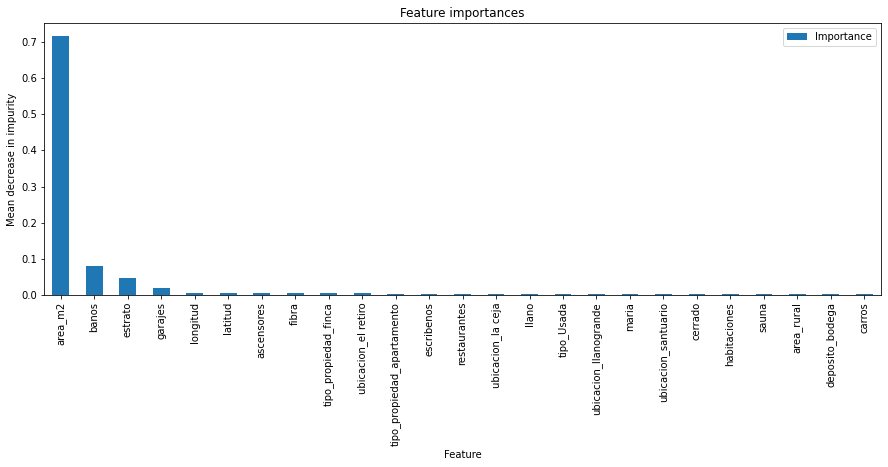

In [ ]:
importances = pipe_gbt[1].feature_importances_
labels= list(X_v.columns)

data2 = zip(labels, importances)


gbt_importances = pd.DataFrame(data2, columns=['Feature','Importance']).sort_values(by=['Importance'], ascending=False)
most_important=gbt_importances.iloc[:25,:]
most_important.set_index('Feature', inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
most_important.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()


In [ ]:
X_v.shape

(2481, 694)


--Realizar stemming and lemmatization

In [ ]:
#para_grid = {'gbt__n_estimators':[100,120,150], 'gbt__max_depth':[6,7,8,9], 'gbt__min_samples_split':[4,5,6], 'gbt__min_samples_leaf':[2,3,4]}
#modelo_gbt = busqueda_hiperparametros(X_train, y_train_t, var_stratify_train, pipe_gbt, param_grid = para_grid, transf=True )

In [ ]:
#metricas_gbt_t = metricas(modelo_gbt.best_estimator_,Y_train, np.expm1(modelo_gbt.predict(X_train)), Y_test, np.expm1(modelo_gbt.predict(X_test)))
#metricas_gbt_t

In [ ]:
#modelo_gbt.best_estimator_

### **XG-Boost con texto - Y sin t**

In [ ]:
import xgboost as xgb

pipe_xgb = Pipeline(steps = [
    ('scaler', StandardScaler()), 
    ('xgb',  xgb.XGBRegressor(
        objective='reg:squarederror', reg_alpha = 3, reg_lambda = 3, max_depth=5, learning_rate=0.05, n_jobs=-1, n_estimators = 175, 
    ))
])


In [ ]:
pipe_xgb.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=175,
                              n_jobs=-1, objective='reg:squarederror',
                              reg_alpha=3, reg_lambda=3))])

In [ ]:
r2_train = r2_score(Y_train,pipe_xgb.predict(X_train))
r2_test = r2_score(Y_test, pipe_xgb.predict(X_test))
print("The model training R2 is" , r2_train)
print("The model test R2 is" , r2_test)

The model training R2 is 0.9300172147293653
The model test R2 is 0.8006016238579401


In [ ]:
metricas_xgb = metricas(pipe_xgb,Y_train, pipe_xgb.predict(X_train), Y_test, pipe_xgb.predict(X_test))
metricas_xgb

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,"XGBRegressor(learning_rate=0.05, max_depth=5, ...",52043392.0,74896320.0,0.150727,0.2114,0.930017,0.800602,1.492777e+08,2.846719e+08


In [ ]:
import io

buffer = io.StringIO()
df_propiedades.info(buf=buffer, max_cols=184)
s = buffer.getvalue()
with open("df_info.txt", "w",
          encoding="utf-8") as f:  
    f.write(s)

In [ ]:
from joblib import dump, load
dump(pipe_xgb, 'xgboost.joblib')

['xgboost.joblib']

In [ ]:
xgb.__version__

'0.90'

In [ ]:
X_train.head(1).to_csv('x_labels.csv')

In [ ]:
X_train.loc[0,'tipo_Nueva']

1.0

In [ ]:
type(pipe_xgb.predict(X_train.head(1))[0])

numpy.float32